In [1]:
import os
import shutil
import subprocess
import gc
import xarray as xr
import numpy as np
import pymp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path, single_plot, change_dataset, _read_step

In [11]:
# Initial setup
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory

#Keel experiments

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT200_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT290_HprodAst_Lx3000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx3000km/cold_keel/keel_stable_DT350_HprodAst_Lx3000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT200_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT290_HprodAst_Lx4000km_ck'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/keel_stable_DT350_HprodAst_Lx4000km_ck'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT290_HprodAst_Lx4000km_ck_aw'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw'


#Thermal boundary condition fixed
scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf_sc'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/shift_craton/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf_sc'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT200_HprodAst_Lx4000km_ck_aw_tbcf'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/ast_wind/keel_stable_DT350_HprodAst_Lx4000km_ck_aw_tbcf'

# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/weak_keel/keel_stable_DT200_PT1292oC_HprodAst_Lx4000km_ck_tbcf_wk_Cmlit01'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/weak_keel/keel_stable_DT200_PT1292oC_HprodAst_Lx4000km_ck_tbcf_wk_Cmlit001'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/weak_keel/keel_stable_DT200_PT1292oC_HprodAst_Lx4000km_ck_tbcf_wk_Cmlit03'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/weak_keel/keel_stable_DT200_PT1292oC_HprodAst_Lx4000km_ck_tbcf_wk_Cmlit05'

#PARTIAL
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_wetol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbwo/mbwo_partial'
# scenario = '/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/mobile_belt/mb_dryol/keel_stable_DT200_HprodAst_Lx4000km_ck_mbdo/mbdo_partial'

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    # scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'
    external_media = 'Joao_Macedo'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}{scenario}"

dataset = xr.open_dataset(f'{model_path}/_output_temperature.nc')

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

instant = dataset.time[-1]

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(dataset.info)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (time: 401, x: 401, z: 71)
Coordinates:
  * time         (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
    step         (time) int32 ...
  * x            (x) float64 0.0 1e+04 2e+04 3e+04 ... 3.98e+06 3.99e+06 4e+06
  * z            (z) float64 -7e+05 -6.9e+05 -6.8e+05 ... -2e+04 -1e+04 0.0
Data variables:
    temperature  (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                401
    nz:                                71
    lx:                                4000000.0
    lz:                                700000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_u

In [199]:
# mobile_belt = True
mobile_belt = False

# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3
# thickness of upper crust (m)
thickness_upper_crust = 20 * 1.0e3
# thickness of lower crust (m)
thickness_lower_crust = 15 * 1.0e3
# total thickness of lithosphere (m)
thickness_litho = 80 * 1.0e3
#shift craton
shift_craton = 0.0e3

if(mobile_belt == False):
        interfaces = {
                "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
                "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
                "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
                "air": np.ones(Nx) * (thickness_sa),
                }

        dx = Lx/(Nx-1)
        # Lcraton = 600.0e3 #m
        Lcraton = 1200.0e3 #m
        # Lcraton = 2000.0e3 #m
        thickening = thickness_litho + 120.e3 #m
        Ncraton = int(Lcraton//dx) #largura em indices
        
        Nshift = int(shift_craton//dx)
        interfaces['litho'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening

else: #with mobile belt
    interfaces = {
        "litho_LAB": np.ones(Nx) * (thickness_litho + thickness_sa), #lab horizontal
        "litho_HETERO": np.ones(Nx) * (thickness_litho + thickness_sa), #interface entre central e lateral -  interface 
        "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
        "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
        "air": np.ones(Nx) * (thickness_sa),
        }

    #Building craton
    dx = Lx/(Nx-1)
    # Lcraton = 600.0e3 #m
    Lcraton = 1200.0e3 #m
#     Lcraton = 2000.0e3 #m
    thickening = thickness_litho + 120.e3 #m

    Ncraton = int(Lcraton//dx) #largura em indices

    Nshift = int(shift_craton//dx)

    interfaces['litho_LAB'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
    
    #Building mobile belt
    interfaces['litho_HETERO'][Nx//2 - Ncraton//2 + Nshift : Nx//2 + Ncraton//2 + Nshift] = thickness_sa + thickening
    Lmb = 300.0e3 #length of mobile belt
    N_Lmb = int(Lmb//dx)
    # thinning = 50.0e3
    thinning = 100.0e3

    interfaces['litho_HETERO'][Nx//2 - N_Lmb//2 + Nshift : Nx//2 + N_Lmb//2 + Nshift] = thickness_sa + thickening - thinning
#
    
#delimiting the limits to extract the particles
lower_lim = interfaces['litho'] + 10
upper_lim = interfaces['air'] - 10

In [13]:
model_path

'/media/joao_macedo/Joao_Macedo/Doutorado/cenarios/mandyoc/keel/Lx4000km/cold_keel/thermal_bc_fixed/keel_stable_DT200_HprodAst_Lx4000km_ck_tbcf'

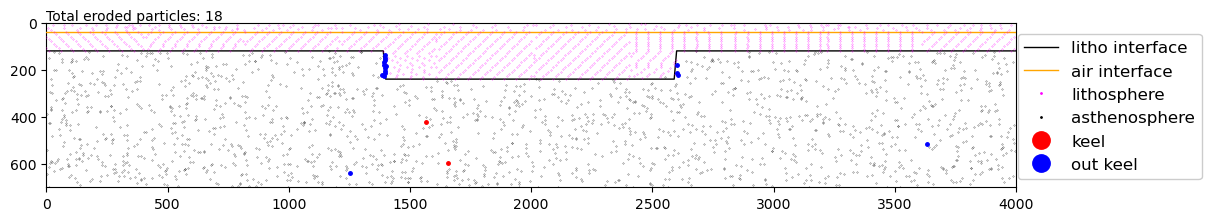

In [226]:
ncores = 20
# i = 0
# i = 100
i = 200

data_x, data_z, data_ID, data_lithology, data_strain = _read_step(model_path, f"step_{int(dataset.step[i].values*1)}_", ncores)

xcenter = (Lx/2) + shift_craton

#selecting particles out of the keel, with z deeper than lithosphere km and lithology = 1 (lithosphere)
cond_out_keel = ((data_x >= 0) & (data_x < xcenter - Lcraton/2) | (data_x > xcenter + Lcraton/2) & (data_x <= Lx))\
                & (data_z < -(thickness_litho + thickness_sa + 10.0e3))\
                & (data_lithology == 1)

data_x_out_keel = data_x[cond_out_keel]
data_z_out_keel = data_z[cond_out_keel]
data_lithology_out_keel = data_lithology[cond_out_keel]

#selecting particles out of the keel, with z deeper than lithosphere + 10 km and lithology = 1 (lithosphere)
cond_keel = (data_x >= xcenter - Lcraton/2) & (data_x <= xcenter + Lcraton/2)\
            & (data_z < -(thickness_litho + thickness_sa + thickening + 10.0e3))\
            & (data_lithology == 1)

data_x_keel = data_x[cond_keel]
data_z_keel = data_z[cond_keel]
data_lithology_keel = data_lithology[cond_keel]

#plotting to test
fig, ax = plt.subplots(1, 1, figsize=(12, 12*(Lz/Lx)), constrained_layout = True)

ax.plot(x, interfaces['litho']/1000, color='black', linestyle='-', linewidth=1.0, alpha=1.0, zorder=30, label='litho interface')
ax.plot(x, interfaces['air']/1000, color='orange', linestyle='-', linewidth=1.0, alpha=1.0, zorder=30, label='air interface')

ax.plot(data_x[data_lithology >= 1][::5]/1000, -data_z[data_lithology >= 1][::5]/1000, "o", color='magenta', markersize=0.2, alpha=1.0, zorder=30, label='lithosphere')
ax.plot(data_x[data_lithology == 0][::5]/1000, -data_z[data_lithology == 0][::5]/1000, "o", color='black', markersize=0.2, alpha=1.0, zorder=30, label='asthenosphere')

ax.plot(data_x_keel/1000, -data_z_keel/1000, "o", color='red', markersize=2.5, alpha=1.0, zorder=30, label='keel')
ax.plot(data_x_out_keel/1000, -data_z_out_keel/1000, "o", color='blue', markersize=2.5, alpha=1.0, zorder=30, label='out keel')

ax.text(0, -10, f"Total eroded particles: {len(data_x_keel) + len(data_x_out_keel)}")

ax.set_xlim([0, Lx/1000])
ax.set_ylim([Lz/1000 - thickness_sa/1.0e3, 0 - thickness_sa/1.0e3])

ax.set_ylim([Lz/1000, 0])

ax.legend(loc='lower right', fontsize=12, frameon=True, framealpha=1.0, facecolor='white', markerscale=5,
          bbox_to_anchor=(1.2, 0.0))
# legend.get_frame().set_facealpha(1.0)

# ax.set_ylim([100, 0 - thickness_sa/1.0e3])
# ax.set_yticks(np.arange(-40, 100, 20))



In [45]:
Lcraton

2000000.0